<a href="https://colab.research.google.com/github/tranmanhcuong253/DistilBERT/blob/main/DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#I.Sentiment Analysis

Source:
* https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
* https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=FoCep_WVuB3v

##1.Import Basic Package

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

##2.Load Dataset

In [ ]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [ ]:
df=df[:2000]

In [ ]:
df[1].value_counts()

1
1    1041
0     959
Name: count, dtype: int64

##3.Loading the Pre-Trained BERT model

In [ ]:
#For DistilBERT
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,transformers.DistilBertTokenizer,'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [ ]:
#Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

##4.Preparing the Dataset

###4.1.Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [ ]:
tokenized = df[0].apply(lambda x: tokenizer.encode(x,add_special_tokens=True))
df['tokenized'] = tokenized
df.head()

,0,1,tokenized
0,"a stirring , funny and finally transporting re...",1,"[101, 1037, 18385, 1010, 6057, 1998, 2633, 182..."
1,apparently reassembled from the cutting room f...,0,"[101, 4593, 2128, 27241, 23931, 2013, 1996, 62..."
2,they presume their audience wo n't sit still f...,0,"[101, 2027, 3653, 23545, 2037, 4378, 24185, 10..."
3,this is a visually stunning rumination on love...,1,"[101, 2023, 2003, 1037, 17453, 14726, 19379, 1..."
4,jonathan parker 's bartleby should have been t...,1,"[101, 5655, 6262, 1005, 1055, 12075, 2571, 376..."


In [ ]:
df[0][0],df['tokenized'][0]

('a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films',
 [101,
  1037,
  18385,
  1010,
  6057,
  1998,
  2633,
  18276,
  2128,
  16603,
  1997,
  5053,
  1998,
  1996,
  6841,
  1998,
  5687,
  5469,
  3152,
  102])

###4.2.Padding
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
type(tokenized)

pandas.core.series.Series

In [ ]:
max_len = 0
for i in tokenized.values:
  if len(i) > max_len:
    max_len=len(i)

In [ ]:
max_len

59

In [ ]:
padded_tokenized = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
padded_tokenized[0]

array([  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128,
       16603,  1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469,
        3152,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [ ]:
padded_tokenized.shape

(2000, 59)

###4.3.Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
x = np.where((5-5)!=0,'a','b')
x

array('b', dtype='<U1')

In [ ]:
attention_mask = np.where(padded_tokenized != 0, 1, 0)
padded_tokenized[0],attention_mask[0]

(array([  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128,
        16603,  1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469,
         3152,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

##5.Run the BERT model
The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [ ]:
input_ids = torch.tensor(padded_tokenized)
attention_mask = torch.tensor(attention_mask)

with torch.inference_mode():
  last_hidden_states = model(input_ids,attention_mask=attention_mask)

In [ ]:
input_ids.shape
attention_mask.shape

torch.Size([2000, 59])

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

After going through the model the [CLS] token learn all about the sentence context, meaning,... So basically, it is the representation of the whole sentence

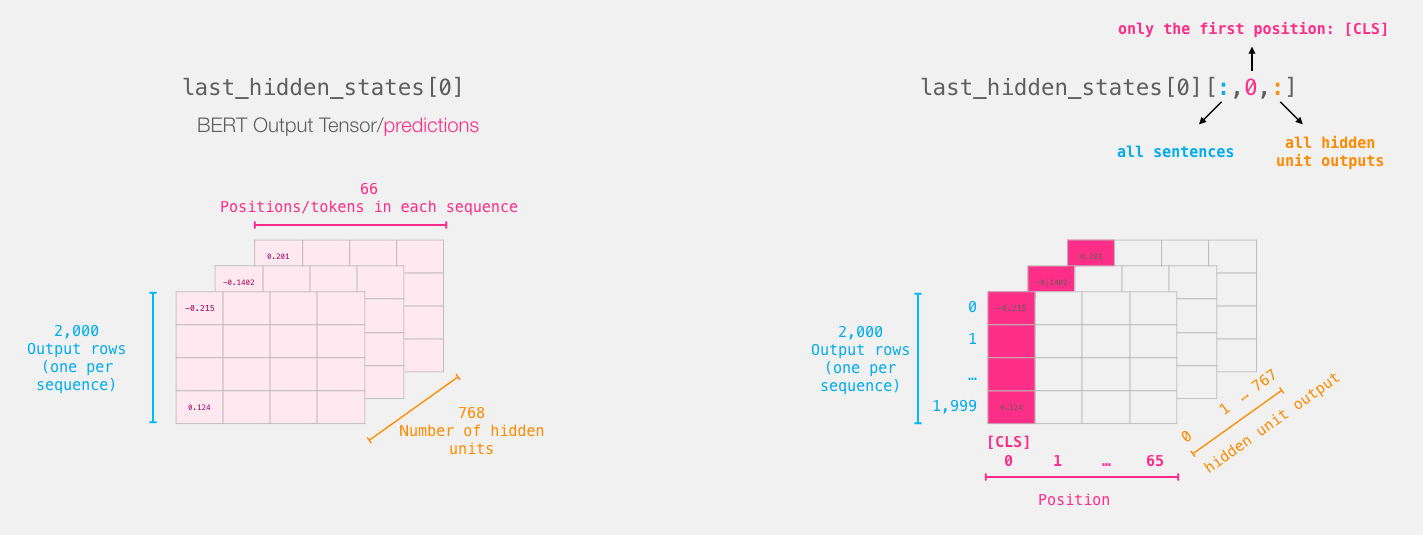

In [ ]:
last_hidden_states[0][0,0,:].shape#sentence 0, token 0 ([CLS]), and all of it hidden states

torch.Size([768])

In [ ]:
last_hidden_states[0].shape

torch.Size([2000, 59, 768])

Because we only want the representation of [CLS] token. We'll save those in the features variable, as they'll serve as the features to our logitics regression model.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape#Every [CLS] token of 2000 sentence

(2000, 768)

In [ ]:
#Extract the labels of each sentence
labels = df[1]
labels

0       1
1       0
2       0
3       1
4       1
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: 1, Length: 2000, dtype: int64

##6.Using the second model: LogisticRegression for classification

###6.1.Split data

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
len(train_features),len(test_features),len(train_labels),len(test_labels)

(1500, 500, 1500, 500)

###6.2.Grid Search for Parameters

In [ ]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 5.26325263e+00, 1.05264053e+01, 1.57895579e+01,
       2.10527105e+01, 2.63158632e+01, 3.15790158e+01, 3.68421684e+01,
       4.21053211e+01, 4.73684737e+01, 5.26316263e+01, 5.78947789e+01,
       6.31579316e+01, 6.84210842e+01, 7.36842368e+01, 7.89473895e+01,
       8.42105421e+01, 8.94736947e+01, 9.47368474e+01, 1.00000000e+02])})

In [ ]:
print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.8140000000000001


###6.3.Fit the model and make prediction

In [ ]:
lr_clf = LogisticRegression(**grid_search.best_params_)
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=5.263252631578947)

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
test_pred=lr_clf.predict(test_features)
print(classification_report(test_labels,test_pred))
print(f'Accuracy: {accuracy_score(test_labels,test_pred)*100:.2f}%')

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       243
           1       0.82      0.87      0.84       257

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500

Accuracy: 83.20%


For reference, the highest accuracy score for this dataset is currently 96.8. DistilBERT can be trained to improve its score on this task – a process called fine-tuning which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of 90.7. The full size BERT model achieves 94.9.

And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at fine-tuning. You can also go back and switch from distilBERT to BERT and see how that works.

##7.Inference/Putting everything together

In [ ]:
sentiment ={1:'positive',0:'negative'}

In [ ]:
def BERT_sentiment_analysis(text):
  #Tokenize the text input
  tokenized = tokenizer.encode(text,add_specical_tokens=True)
  #Because we only take in one sentence so we don't need padding and mmasking
  input_ids = torch.tensor(tokenized)
  #Feed into the BERT model so we can get embedding vector
  with torch.inference_mode():
    last_hidden_states = model(input_ids.unsqueeze(0))
  #For sentiment annalysis task we only need to take the embedding of the first token which is [CLS]
  features = last_hidden_states[0][:,0,:].numpy()

  #Feed into the second model LogisticRegression for classification
  return lr_clf.predict(features)


In [ ]:
text =  'loving and joyful'
sent = BERT_sentiment_analysis(text)
print(text,':',sentiment[sent.item()])

Keyword arguments {'add_specical_tokens': True} not recognized.


loving and joyful : positive


#II.Text Classification

##1.Import Basic Package

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import get_linear_schedule_with_warmup, AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


##2.Load and Preprocess Datasets

In [ ]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
data=fetch_20newsgroups(
            subset='all',
            categories=['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
            shuffle=False,
            remove=('headers', 'footers', 'quotes'))

In [ ]:
target_names = data.target_names
target_names

['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

In [ ]:
len(data['data'])


3952

In [ ]:
df = pd.DataFrame([data.data, data.target.tolist()]).T
df.columns = ['text', 'target']

In [ ]:
df.head()

,text,target
0,Archive-name: cryptography-faq/part10\nLast-mo...,0
1,Does anyone on this newsgroup happen to know W...,2
2,"Hi,\n\tI am looking for some help in choosing ...",1
3,Does anyone know of a non-word password genera...,0
4,"The system, or 'family', key would appear to b...",0


In [ ]:
# remove excess white spaces
df['text'] = df['text'].apply(lambda x: " ".join(x.split()))

# remove excess spaces near punctuation
df['text'] = df['text'].apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', x))

##3.Tokenize the Data

In [ ]:
# instantiate BERT tokenizer with upper + lower case
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_corpus(df, tokenizer, max_len):
    # max len -- 512 is max
    max_len = max_len
    # for every document:

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        df,  # document to encode.
                        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
                        max_length=max_len,  # set max length
                        truncation=True,  # truncate longer messages
                        padding='max_length',  # add padding
                        return_attention_mask=True,  # create attn. masks
                    )

    # add the tokenized sentence to the list
    input_ids=encoded_dict['input_ids']

    # and its attention mask (differentiates padding from non-padding)
    attention_masks=encoded_dict['attention_mask']

    return torch.tensor(input_ids), torch.tensor(attention_masks)

In [ ]:
# Create tokenized data
tokenized_data = df['text'].apply(lambda x: tokenize_corpus(x, tokenizer, 512))

# Unpack tokenized_data into input_ids and attention_masks
input_ids, attention_masks = zip(*tokenized_data)

Bacause `input_ids` and `attention_masks` are tuples so we need to convert them into tensor by using `stack()`

In [ ]:
input_ids = torch.stack(input_ids)
attention_masks=torch.stack(attention_masks)
input_ids.shape,attention_masks.shape

(torch.Size([3952, 512]), torch.Size([3952, 512]))

In [ ]:
# convert the labels into tensors.
labels = torch.tensor(df['target'].values.astype(np.float32))

In [ ]:
labels.shape

torch.Size([3952])

##4.Split Dataset and feed into DataLoader

In [ ]:
# prepare tensor data sets
def prepare_dataset(padded_tokens, attention_masks, target):
    # prepare target into np array
    target = np.array(target.values, dtype=np.int64).reshape(-1, 1)
    # create tensor data sets
    tensor_df = TensorDataset(padded_tokens, attention_masks, torch.from_numpy(target))
    # 80% of df
    train_size = int(0.8 * len(df))
    # 20% of df
    val_size = len(df) - train_size
    # 50% of validation
    test_size = int(val_size - 0.5*val_size)
    # divide the dataset by randomly selecting samples
    train_dataset, val_dataset = random_split(tensor_df, [train_size, val_size])
    # divide validation by randomly selecting samples
    val_dataset, test_dataset = random_split(val_dataset, [test_size, test_size+1])

    return train_dataset, val_dataset, test_dataset

In [ ]:
# create tenor data sets
train_dataset, val_dataset, test_dataset = prepare_dataset(input_ids,
                                                           attention_masks,
                                                           df['target'])

In [ ]:
len(train_dataset),len(val_dataset),len(test_dataset)

(3161, 395, 396)

In [ ]:
# create DataLoaders with samplers
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=False)

valid_dataloader = DataLoader(val_dataset,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                              batch_size=32,
                              shuffle=True)

In [ ]:
len(train_dataloader),len(valid_dataloader),len(test_dataloader)

(99, 13, 13)

##5.Prepare Train, Validation and Testing Functions

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(model, dataloader, optimizer,device):
  # Perform one full pass over the training set.
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
  print('Training...')

  # reset total loss for epoch
  train_total_loss = 0
  total_train_acc = 0

  # put model into traning mode
  model.train()
  # for each batch of training data...
  for step, batch in enumerate(dataloader):

      # progress update every 40 batches.
      if step % 40 == 0 and not step == 0:

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

      # Unpack this training batch from our dataloader:
      #
      # As we unpack the batch, we'll also copy each tensor to the GPU using
      # the `to` method.
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids
      #   [1]: attention masks
      #   [2]: labels
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].long().to(device)

      # forward propagation (evaluate model on training batch)
      outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits
      # sum the training loss over all batches for average loss at end
      # loss is a tensor containing a single value
      train_total_loss += loss.item()

      # clear previously calculated gradients
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      # move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      y_true = b_labels.detach().cpu().numpy()

      # calculate preds
      rounded_preds = np.argmax(logits, axis=1).flatten()

      # calculate accuracy
      total_train_acc += accuracy_score(rounded_preds, y_true)


  # calculate the average loss over all of the batches
  avg_train_loss = train_total_loss / len(dataloader)

  # calculate the average f1 over all of the batches
  avg_train_acc = total_train_acc / len(dataloader)

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'Train Loss': avg_train_loss,
          'Train Acc': avg_train_acc
      }
  )
  # print result summaries
  print("")
  print("summary results")
  print("epoch | trn loss | trn acc ")
  print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {avg_train_acc:.5f} | ")




In [ ]:
def validating(model, dataloader,device):


    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_accuracy = 0
    total_valid_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.inference_mode():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)
            logits=outputs.logits
            loss=outputs.loss

        # accumulate validation loss
        total_valid_loss += loss.item()

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy()

        # calculate preds
        rounded_preds = np.argmax(logits, axis=1).flatten()

        # calculate accuracy
        total_valid_accuracy += accuracy_score(rounded_preds, y_true)

    # report final accuracy of validation run
    avg_accuracy = total_valid_accuracy / len(dataloader)

    avg_val_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_val_loss,
            'Val Accur.': avg_accuracy,
        }
    )


    # print result summaries
    print("")
    print("summary results")
    print("epoch | val loss | val acc")
    print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {avg_accuracy:.5f}")


In [ ]:
def testing(model, dataloader,device):


    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Testing...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_test_accuracy = 0
    total_test_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.inference_mode():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)
            logits=outputs.logits
            loss=outputs.loss

        # accumulate validation loss
        total_test_loss += loss.item()

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy()

        # calculate preds
        rounded_preds = np.argmax(logits, axis=1).flatten()

        # calculate accuracy
        total_test_accuracy += accuracy_score(rounded_preds, y_true)

    # report final accuracy of validation run
    avg_accuracy = total_test_accuracy / len(dataloader)

    avg_test_loss = total_test_loss / len(dataloader)

    # Record all statistics from this epoch.
    test_stats.append(
        {
            'Val Loss': avg_test_loss,
            'Val Accur.': avg_accuracy,
        }
    )




##6.Load the pretrain DistilBert model

In [ ]:
# Load DistilBERT with a single a single linear classification layer
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-cased",
    num_labels=4).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

##7.Training model

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=3.306430502342561e-06,
                  weight_decay=0.65
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5
training_stats = []
valid_stats = []
best_valid_loss = float('inf')
for epoch in range(epochs):
    # train
    train(model, train_dataloader, optimizer,device)
    # validate
    validating(model, valid_dataloader,device)
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        print('Saving model ...')
        best_valid_loss = valid_stats[epoch]['Val Loss']
        # save best model for use later
        torch.save(model.state_dict(), 'distilbert-model1.pt')  # torch save
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('./model_save/')  # transformers save
        tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 5 ========
Training...
  Batch    40  of     99.
  Batch    80  of     99.

summary results
epoch | trn loss | trn acc 
    1 | 0.31283 | 0.89864 | 

Running Validation...

summary results
epoch | val loss | val acc
    1 | 0.39539 | 0.84637
Saving model ...

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     99.
  Batch    80  of     99.

summary results
epoch | trn loss | trn acc 
    2 | 0.27324 | 0.91000 | 

Running Validation...

summary results
epoch | val loss | val acc
    2 | 0.38461 | 0.85140
Saving model ...

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     99.
  Batch    80  of     99.

summary results
epoch | trn loss | trn acc 
    3 | 0.23499 | 0.92564 | 

Running Validation...

summary results
epoch | val loss | val acc
    3 | 0.36996 | 0.86320
Saving model ...

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     99.
  Batch    80  of     99.

summary results
epoch | trn loss | trn acc 
    4 | 0.20897 | 0.932

##8.Visualizing Results

In [ ]:
# organize results
pd.set_option('display.precision', 3)
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
df_stats

,Train Loss,Train Acc,Val Loss,Val Accur.
Epoch,,,,
1,0.313,0.899,0.395,0.846
2,0.273,0.910,0.385,0.851
3,0.235,0.926,0.370,0.863
4,0.209,0.933,0.364,0.861
5,0.183,0.941,0.380,0.864


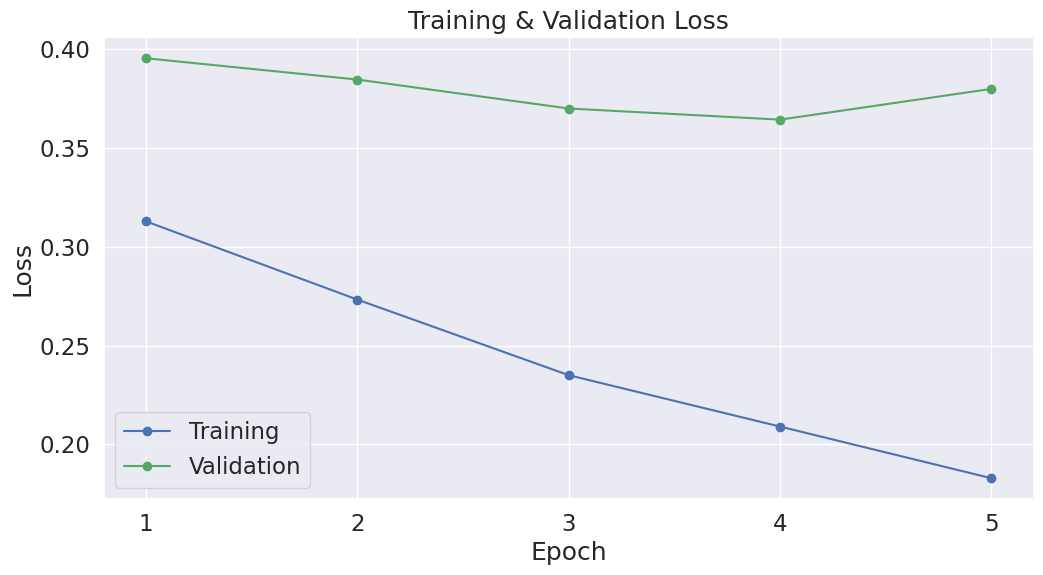

In [ ]:
# plot results
def plot_results(df):
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()


plot_results(df_stats)

##9.Testing model and Inference with random single text

In [ ]:
# test the model
test_stats = []
model.load_state_dict(torch.load('distilbert-model1.pt'))

<All keys matched successfully>

In [ ]:
testing(model, test_dataloader,device)


Running Testing...


In [ ]:
df_test_stats = pd.DataFrame(data=test_stats)
df_test_stats

,Val Loss,Val Accur.
0,0.405,0.849


In [ ]:
#Inference with single text

In [ ]:
text = 'In the realm of modern technology, circuits weave intricate pathways for currents to flow, powering devices that seamlessly integrate into our lives, connecting us to a vast digital landscape of information and communication. From humble beginnings to microprocessor marvels, electronics continuously push the boundaries of innovation, shaping our daily experiences.'

In [ ]:
text =input()

 In the vast expanse beyond our atmosphere, intricate systems hum with energy, orchestrating the dance of distant signals and celestial bodies. Among these cosmic mechanisms, delicate circuits navigate the celestial currents, ensuring seamless communication across cosmic distances.


In [ ]:
def predict_class(text,tokenizer,model,target_names,device):
  # Create tokenized data
  tokenized_data = tokenize_corpus(text, tokenizer, 512)

  # Unpack tokenized_data into input_ids and attention_masks
  input_ids, attention_masks = tokenized_data

  #Feed into the model to get the logits
  with torch.inference_mode():
    logits = model(input_ids=input_ids.to(device),attention_mask=attention_masks.to(device)).logits

  #Getting probabilities
  prob = torch.softmax(logits,dim=-1).squeeze().tolist()
  #Getting the label
  label = torch.argmax(logits,dim=-1).item()

  print(f'Text: {text}\nBelong to class [{target_names[label]}]')
  for i in range(len(target_names)):
    print(f'Label: [{target_names[i]}] with probability {prob[i]*100:.2f}%')


In [ ]:
predict_class(text,tokenizer,model,target_names,device)

Text:  In the vast expanse beyond our atmosphere, intricate systems hum with energy, orchestrating the dance of distant signals and celestial bodies. Among these cosmic mechanisms, delicate circuits navigate the celestial currents, ensuring seamless communication across cosmic distances.
Belong to class [sci.space]
Label: [sci.crypt] with probability 0.76%
Label: [sci.electronics] with probability 0.58%
Label: [sci.med] with probability 1.05%
Label: [sci.space] with probability 97.61%
